# 初步探索poisson table
- log2_FC: log2(treat_count.norm/ctrl_count.norm), 如果ctrl_count.norm不存在，就用 chr 突变背景
- log2_FC_mut: log2(treat_mut_count.norm/ctrl_mut_count.norm), 如果ctrl_mut_count.norm不存在，就用 chr 突变背景
- region_block_state: B-Blocked, S-SNV, N-Non-SNV

In [10]:
import collections
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycircos
from pycircos import Garc, Gcircle

In [11]:
file = '../poisson_res/poisson_res_all.tsv.gz'

In [12]:
df = pd.read_csv(file, header=0, index_col=None, sep='\t')
df.head()

,<sample>,chr_name,region_start,region_end,mpmat_index,region_site_num,region_block_site_num,region_mut_site_num,region_site_index,region_block_state,...,ctrl_count.norm,treat_count.norm,ctrl_mut_count.norm,treat_mut_count.norm,count_info,log2_FC,log2_FC_mut,test_state,p_value,FDR
0,DetectSeq_ATP8-DddA11_REP-1,chr1,31029,31037,chr1_31029_31037,4,1,3,"chr1_31029_GA,chr1_31030_G.,chr1_31031_GA,chr1...",B-N-N-N,...,0.005063,0.035765,0.0,0.005961,"0,1,2,3,4 2,0,0,0,0 5,0,1,0,0",2.820479,-0.442445,TestOK,0.582932,0.714251
1,DetectSeq_ATP8-DddA11_REP-1,chr1,56485,56490,chr1_56485_56490,4,1,3,"chr1_56485_CT,chr1_56487_CT,chr1_56488_C.,chr1...",B-N-N-N,...,0.025315,0.041726,0.0,0.005961,"0,1,2,3,4 10,0,0,0,0 6,0,1,0,0",0.720943,-0.442445,TestOK,0.582932,0.714251
2,DetectSeq_ATP8-DddA11_REP-1,chr1,56638,56647,chr1_56638_56647,3,0,3,"chr1_56638_CT,chr1_56641_C.,chr1_56647_CT",N-N-N,...,0.040504,0.077491,0.0,0.000000,"0,1,2,3 16,0,0,0 3,10,0,0",0.935956,NaN,TestOK,0.841752,0.841765
3,DetectSeq_ATP8-DddA11_REP-1,chr1,63226,63239,chr1_63226_63239,5,1,4,"chr1_63226_CT,chr1_63227_C.,chr1_63230_CT,chr1...",N-N-N-N-B,...,0.053162,0.065569,0.0,0.005961,"0,1,2,3,4,5 21,0,0,0,0,0 10,0,0,1,0,0",0.302631,-0.442445,TestOK,0.582932,0.714251
4,DetectSeq_ATP8-DddA11_REP-1,chr1,70291,70300,chr1_70291_70300,3,0,3,"chr1_70291_CT,chr1_70292_CA,chr1_70300_CT",N-N-N,...,0.040504,0.113256,0.0,0.011922,"0,1,2,3 15,1,0,0 11,6,2,0",1.483444,0.557555,TestOK,0.377620,0.580319


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562657 entries, 0 to 1562656
Data columns (total 28 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   <sample>                       1562657 non-null  object 
 1   chr_name                       1562657 non-null  object 
 2   region_start                   1562657 non-null  int64  
 3   region_end                     1562657 non-null  int64  
 4   mpmat_index                    1562657 non-null  object 
 5   region_site_num                1562657 non-null  int64  
 6   region_block_site_num          1562657 non-null  int64  
 7   region_mut_site_num            1562657 non-null  int64  
 8   region_site_index              1562657 non-null  object 
 9   region_block_state             1562657 non-null  object 
 10  region_highest_site_index      1546820 non-null  object 
 11  region_highest_site_mut_num    1562657 non-null  int64  
 12  region_highest

In [14]:
df.isna().sum()

<sample>                              0
chr_name                              0
region_start                          0
region_end                            0
mpmat_index                           0
region_site_num                       0
region_block_site_num                 0
region_mut_site_num                   0
region_site_index                     0
region_block_state                    0
region_highest_site_index         15837
region_highest_site_mut_num           0
region_highest_site_cover_num         0
region_highest_site_mut_ratio         0
ctrl_count                            0
treat_count                           0
ctrl_mut_count                        0
treat_mut_count                       0
ctrl_count.norm                       0
treat_count.norm                      0
ctrl_mut_count.norm                   0
treat_mut_count.norm                  0
count_info                            0
log2_FC                               0
log2_FC_mut                      229694


In [15]:
# # 查看一下两列 NA 是什么
# test_df = df.query('region_highest_site_index.isna()')
# test2_df = df.query('log2_FC_mut.isna()')

In [17]:
df = df.assign(
    bed_name=df.mpmat_index + '_highest_' + df.region_highest_site_index,
    strand='.'
)
df

,<sample>,chr_name,region_start,region_end,mpmat_index,region_site_num,region_block_site_num,region_mut_site_num,region_site_index,region_block_state,...,ctrl_mut_count.norm,treat_mut_count.norm,count_info,log2_FC,log2_FC_mut,test_state,p_value,FDR,bed_name,strand
0,DetectSeq_ATP8-DddA11_REP-1,chr1,31029,31037,chr1_31029_31037,4,1,3,"chr1_31029_GA,chr1_31030_G.,chr1_31031_GA,chr1...",B-N-N-N,...,0.0,0.005961,"0,1,2,3,4 2,0,0,0,0 5,0,1,0,0",2.820479,-0.442445,TestOK,0.582932,0.714251,chr1_31029_31037_highest_chr1_31031_GA,.
1,DetectSeq_ATP8-DddA11_REP-1,chr1,56485,56490,chr1_56485_56490,4,1,3,"chr1_56485_CT,chr1_56487_CT,chr1_56488_C.,chr1...",B-N-N-N,...,0.0,0.005961,"0,1,2,3,4 10,0,0,0,0 6,0,1,0,0",0.720943,-0.442445,TestOK,0.582932,0.714251,chr1_56485_56490_highest_chr1_56487_CT,.
2,DetectSeq_ATP8-DddA11_REP-1,chr1,56638,56647,chr1_56638_56647,3,0,3,"chr1_56638_CT,chr1_56641_C.,chr1_56647_CT",N-N-N,...,0.0,0.000000,"0,1,2,3 16,0,0,0 3,10,0,0",0.935956,NaN,TestOK,0.841752,0.841765,chr1_56638_56647_highest_chr1_56638_CT,.
3,DetectSeq_ATP8-DddA11_REP-1,chr1,63226,63239,chr1_63226_63239,5,1,4,"chr1_63226_CT,chr1_63227_C.,chr1_63230_CT,chr1...",N-N-N-N-B,...,0.0,0.005961,"0,1,2,3,4,5 21,0,0,0,0,0 10,0,0,1,0,0",0.302631,-0.442445,TestOK,0.582932,0.714251,chr1_63226_63239_highest_chr1_63226_CT,.
4,DetectSeq_ATP8-DddA11_REP-1,chr1,70291,70300,chr1_70291_70300,3,0,3,"chr1_70291_CT,chr1_70292_CA,chr1_70300_CT",N-N-N,...,0.0,0.011922,"0,1,2,3 15,1,0,0 11,6,2,0",1.483444,0.557555,TestOK,0.377620,0.580319,chr1_70291_70300_highest_chr1_70300_CT,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562652,DetectSeq_SIRT6-DddA11_REP-1,chrX,155948218,155948220,chrX_155948218_155948220,2,0,2,"chrX_155948218_CT,chrX_155948220_CT",N-N,...,0.0,0.000000,"0,1,2 0,0,0 5,0,4",-0.208028,NaN,TestOK,0.806282,0.846502,chrX_155948218_155948220_highest_chrX_15594821...,.
1562653,DetectSeq_SIRT6-DddA11_REP-1,chrX,155948229,155948244,chrX_155948229_155948244,4,0,4,"chrX_155948229_GA,chrX_155948233_GA,chrX_15594...",N-N-N-N,...,0.0,0.000000,"0,1,2,3,4 0,0,0,0,0 5,0,0,4,0",-0.208028,NaN,TestOK,0.806282,0.846502,chrX_155948229_155948244_highest_chrX_15594822...,.
1562654,DetectSeq_SIRT6-DddA11_REP-1,chrX,155974406,155974427,chrX_155974406_155974427,7,0,7,"chrX_155974406_CT,chrX_155974413_CT,chrX_15597...",N-N-N-N-N-N-N,...,0.0,0.016684,"0,1,2,3,4,5,6,7 0,0,0,0,0,0,0,0 17,4,1,2,0,0,0,0",1.207009,1.310806,TestOK,0.192759,0.318252,chrX_155974406_155974427_highest_chrX_15597442...,.
1562655,DetectSeq_SIRT6-DddA11_REP-1,chrX,156022047,156022062,chrX_156022047_156022062,4,0,4,"chrX_156022047_GA,chrX_156022048_GA,chrX_15602...",N-N-N-N,...,0.0,0.016684,"0,1,2,3,4 0,0,0,0,0 4,6,3,0,0",0.322486,1.310806,TestOK,0.192759,0.318252,chrX_156022047_156022062_highest_chrX_15602206...,.


# find significant region

## strict selection 

In [18]:
df_sign_strict = (df
                  .query('FDR <= 0.0001')  # 10911
                  .query('log2_FC_mut >= 2')  # 10911
                  .query('ctrl_mut_count <= 1')  # 9551
                  .query('`treat_mut_count.norm` * 100 >= 10')  # 9551
                  .query('treat_mut_count >= 20')  # 9551
                  .query('treat_mut_count / treat_count >= 0.15')  # 6080
                  .query('region_block_site_num <= 1')  # 5720
                  .query('region_highest_site_mut_ratio >= 0.35')  # 2929
                  )

print(df_sign_strict.shape[0])
df_sign_strict.groupby('<sample>').describe()

2929


region_start                              \
                                    count          mean           std   
<sample>                                                                
DetectSeq_ATP8-DddA11_REP-1         160.0  7.232652e+07  5.417281e+07   
DetectSeq_ATP8-DddA6_REP-1          369.0  7.323834e+07  5.282204e+07   
DetectSeq_ATP8-DddAwt_REP-1          88.0  5.356781e+07  4.259521e+07   
DetectSeq_JAK2-DddA11_REP-1         603.0  7.351632e+07  5.350346e+07   
DetectSeq_SIRT6-DddA11_REP-1       1709.0  7.521779e+07  5.457469e+07   

                                                                               \
                                   min          25%         50%           75%   
<sample>                                                                        
DetectSeq_ATP8-DddA11_REP-1   630957.0  27081692.75  60138169.5  1.142059e+08   
DetectSeq_ATP8-DddA6_REP-1    630440.0  30522027.00  60296487.0  1.121915e+08   
DetectSeq_ATP8-DddAwt_REP-1   631391.0  22923202.25  49321013.5  6.067799e+07   
DetectSeq_JAK2-DddA11_REP-1   686172.0  32317164.50  60225127.0  1.082117e+08   
DetectSeq_SIRT6-DddA11_REP-1  242415.0  31532755.00  60917089.0  1.103109e+08   

                                          region_end                ...  \
                                      max      count          mean  ...   
<sample>                                                            ...   
DetectSeq_ATP8-DddA11_REP-1   242043276.0      160.0  7.232658e+07  ...   
DetectSeq_ATP8-DddA6_REP-1    230513936.0      369.0  7.323841e+07  ...   
DetectSeq_ATP8-DddAwt_REP-1   201232409.0       88.0  5.356787e+07  ...   
DetectSeq_JAK2-DddA11_REP-1   246696632.0      603.0  7.351637e+07  ...   
DetectSeq_SIRT6-DddA11_REP-1  248905893.0     1709.0  7.521785e+07  ...   

                                   p_value                   FDR            \
                                       75%           max   count      mean   
<sample>                                                                     
DetectSeq_ATP8-DddA11_REP-1   5.548434e-09  4.032488e-07   160.0  0.000006   
DetectSeq_ATP8-DddA6_REP-1    2.354367e-08  5.105593e-07   369.0  0.000010   
DetectSeq_ATP8-DddAwt_REP-1   8.644648e-09  1.531386e-07    88.0  0.000009   
DetectSeq_JAK2-DddA11_REP-1   1.114112e-08  6.482170e-07   603.0  0.000009   
DetectSeq_SIRT6-DddA11_REP-1  1.577425e-08  1.137115e-06  1709.0  0.000007   

                                                                     \
                                   std            min           25%   
<sample>                                                              
DetectSeq_ATP8-DddA11_REP-1   0.000015   0.000000e+00  1.145206e-20   
DetectSeq_ATP8-DddA6_REP-1    0.000023   0.000000e+00  1.200588e-11   
DetectSeq_ATP8-DddAwt_REP-1   0.000018   0.000000e+00  1.705089e-11   
DetectSeq_JAK2-DddA11_REP-1   0.000022   1.172614e-99  4.837212e-18   
DetectSeq_SIRT6-DddA11_REP-1  0.000016  6.405502e-146  3.677355e-16   

                                                                
                                       50%       75%       max  
<sample>                                                        
DetectSeq_ATP8-DddA11_REP-1   3.628154e-09  0.000002  0.000086  
DetectSeq_ATP8-DddA6_REP-1    1.471017e-07  0.000006  0.000098  
DetectSeq_ATP8-DddAwt_REP-1   9.436538e-08  0.000005  0.000067  
DetectSeq_JAK2-DddA11_REP-1   5.682422e-10  0.000002  0.000099  
DetectSeq_SIRT6-DddA11_REP-1  2.551968e-09  0.000002  0.000091  

[5 rows x 160 columns]

In [19]:
df_sign_strict.isna().sum().sum()

0

## lenient selection

In [20]:
df_sign_lenient = (df
                   .query('FDR <= 0.01')  # 25118
                   .query('log2_FC_mut >= 2')  # 25118
                   .query('ctrl_mut_count <= 1')  # 22009
                   .query('`treat_mut_count.norm` * 100 >= 5')  # 22009
                   .query('treat_mut_count >= 10')  # 22009
                   .query('treat_mut_count / treat_count >= 0.15')  # 14476
                   .query('region_block_site_num <= 1')  # 13522
                   .query('region_highest_site_mut_ratio >= 0.30')  # 7001
                   )

print(df_sign_lenient.shape[0])
df_sign_lenient.groupby('<sample>').describe()

7001


region_start                              \
                                    count          mean           std   
<sample>                                                                
DetectSeq_ATP8-DddA11_REP-1         390.0  7.140489e+07  5.268447e+07   
DetectSeq_ATP8-DddA6_REP-1         1062.0  7.820919e+07  5.445423e+07   
DetectSeq_ATP8-DddAwt_REP-1         198.0  5.664861e+07  4.505448e+07   
DetectSeq_JAK2-DddA11_REP-1        1122.0  7.074730e+07  5.271937e+07   
DetectSeq_SIRT6-DddA11_REP-1       4229.0  7.598211e+07  5.510585e+07   

                                                                              \
                                   min          25%         50%          75%   
<sample>                                                                       
DetectSeq_ATP8-DddA11_REP-1   630957.0  26449309.50  59933966.5  109372023.5   
DetectSeq_ATP8-DddA6_REP-1     58741.0  34931723.00  65550265.5  113457006.0   
DetectSeq_ATP8-DddAwt_REP-1   631391.0  22815892.00  50126483.5   62436712.5   
DetectSeq_JAK2-DddA11_REP-1   497136.0  28627039.75  58011844.5  103544116.5   
DetectSeq_SIRT6-DddA11_REP-1   49953.0  31975522.00  62469941.0  111973236.0   

                                          region_end                ...  \
                                      max      count          mean  ...   
<sample>                                                            ...   
DetectSeq_ATP8-DddA11_REP-1   242043276.0      390.0  7.140495e+07  ...   
DetectSeq_ATP8-DddA6_REP-1    246387176.0     1062.0  7.820925e+07  ...   
DetectSeq_ATP8-DddAwt_REP-1   228622163.0      198.0  5.664866e+07  ...   
DetectSeq_JAK2-DddA11_REP-1   246696632.0     1122.0  7.074735e+07  ...   
DetectSeq_SIRT6-DddA11_REP-1  248905893.0     4229.0  7.598216e+07  ...   

                               p_value               FDR                      \
                                   75%       max   count      mean       std   
<sample>                                                                       
DetectSeq_ATP8-DddA11_REP-1   0.000013  0.000071   390.0  0.001397  0.002228   
DetectSeq_ATP8-DddA6_REP-1    0.000022  0.000111  1062.0  0.001802  0.002871   
DetectSeq_ATP8-DddAwt_REP-1   0.000007  0.000040   198.0  0.001615  0.002530   
DetectSeq_JAK2-DddA11_REP-1   0.000010  0.000131  1122.0  0.001164  0.002306   
DetectSeq_SIRT6-DddA11_REP-1  0.000033  0.000308  4229.0  0.001592  0.002827   

                                                                               \
                                        min           25%       50%       75%   
<sample>                                                                        
DetectSeq_ATP8-DddA11_REP-1    0.000000e+00  7.914552e-09  0.000078  0.001880   
DetectSeq_ATP8-DddA6_REP-1     0.000000e+00  3.674352e-07  0.000188  0.002568   
DetectSeq_ATP8-DddAwt_REP-1    0.000000e+00  1.808493e-07  0.000127  0.002013   
DetectSeq_JAK2-DddA11_REP-1    1.172614e-99  1.105413e-11  0.000005  0.001209   
DetectSeq_SIRT6-DddA11_REP-1  6.405502e-146  2.534612e-09  0.000032  0.001646   

                                        
                                   max  
<sample>                                
DetectSeq_ATP8-DddA11_REP-1   0.008006  
DetectSeq_ATP8-DddA6_REP-1    0.009767  
DetectSeq_ATP8-DddAwt_REP-1   0.009130  
DetectSeq_JAK2-DddA11_REP-1   0.009687  
DetectSeq_SIRT6-DddA11_REP-1  0.009766  

[5 rows x 160 columns]

In [21]:
df_sign_lenient.isna().sum().sum()

0

In [22]:
dt_mpmat_index = {}

for sample, _df in df_sign_lenient.groupby('<sample>'):
    dt_mpmat_index[sample] = _df.mpmat_index

dt_mpmat_index

{'DetectSeq_ATP8-DddA11_REP-1': 59              chr1_630957_631045
 65              chr1_631232_631310
 75              chr1_631598_631648
 81              chr1_631823_631921
 83              chr1_631932_632007
                     ...           
 189977      chrX_92358078_92358112
 191674    chrX_110310565_110310622
 193006    chrX_122585322_122585394
 194926    chrX_150683676_150683748
 195024    chrX_152959065_152959082
 Name: mpmat_index, Length: 390, dtype: object,
 'DetectSeq_ATP8-DddA6_REP-1': 195192          chr1_630440_630496
 195206          chr1_630957_631045
 195213          chr1_631215_631288
 195224          chr1_631617_631668
 195233          chr1_631955_632018
                     ...           
 493492    chrX_138345116_138345175
 493625    chrX_139687871_139687919
 494699    chrX_152959065_152959082
 494773    chrX_154369783_154369844
 494888    chrX_155570076_155570156
 Name: mpmat_index, Length: 1062, dtype: object,
 'DetectSeq_ATP8-DddAwt_REP-1': 494989          ch

In [23]:
# TODO
def check_mpmat_index_in_others(x):
    dt_mpmat_index_isin = dict()

    for sample, sample_mpmat_index in dt_mpmat_index.items():
        if x['mpmat_index'] in sample_mpmat_index:
            pass

In [24]:
df_igv = df_sign_lenient[['chr_name', 'region_start', 'region_end', 'bed_name', 'log2_FC_mut']]
df_igv.head()

,chr_name,region_start,region_end,bed_name,log2_FC_mut
59,chr1,630957,631045,chr1_630957_631045_highest_chr1_631036_CT,10.711107
65,chr1,631232,631310,chr1_631232_631310_highest_chr1_631247_CT,9.531969
75,chr1,631598,631648,chr1_631598_631648_highest_chr1_631637_CT,8.361686
81,chr1,631823,631921,chr1_631823_631921_highest_chr1_631896_CT,10.735363
83,chr1,631932,632007,chr1_631932_632007_highest_chr1_631994_CT,9.637039


# IGV 截图脚本

In [25]:
# 理论上这里得到的是所有 samples 的 candidate list
# 经过先 merge mpmat 的处理，再 call 点，应该不存在能 overlap 到一起的 region，只能是样本间 share 相同位置或者 not share，不存在 overlap 又不相同的情况了

In [26]:
df_igv.head()

,chr_name,region_start,region_end,bed_name,log2_FC_mut
59,chr1,630957,631045,chr1_630957_631045_highest_chr1_631036_CT,10.711107
65,chr1,631232,631310,chr1_631232_631310_highest_chr1_631247_CT,9.531969
75,chr1,631598,631648,chr1_631598_631648_highest_chr1_631637_CT,8.361686
81,chr1,631823,631921,chr1_631823_631921_highest_chr1_631896_CT,10.735363
83,chr1,631932,632007,chr1_631932_632007_highest_chr1_631994_CT,9.637039


In [27]:
# 整理df格式为bed文件格式
print(df_igv)
#        0          1          2
# 0   chr5   69093805   69093830
# 1   chr8   37153384   37153424
# 2  chr15   57559994   57560017
# 3  chr15   68651256   68651277
# 4  chr10  119445511  119445546
# 5   chr8   20184990   20185028
# 6  chr19   45187694   45187712
# 7  chr15   81265992   81266016
# 8   chr2  201232409  201232430
# 9   chr9   98034893   98034930

        chr_name  region_start  region_end  \
59          chr1        630957      631045   
65          chr1        631232      631310   
75          chr1        631598      631648   
81          chr1        631823      631921   
83          chr1        631932      632007   
...          ...           ...         ...   
1562475     chrX     154457793   154457822   
1562532     chrX     154924102   154924198   
1562550     chrX     155049207   155049224   
1562610     chrX     155439898   155439954   
1562620     chrX     155571427   155571450   

                                                  bed_name  log2_FC_mut  
59               chr1_630957_631045_highest_chr1_631036_CT    10.711107  
65               chr1_631232_631310_highest_chr1_631247_CT     9.531969  
75               chr1_631598_631648_highest_chr1_631637_CT     8.361686  
81               chr1_631823_631921_highest_chr1_631896_CT    10.735363  
83               chr1_631932_632007_highest_chr1_631994_CT     9.637039  
...

In [28]:
# 填写相关信息

path_out = '/Volumes/zhaohn_HD/3.project/2022_DdCBE-3D-Genome_topic/2022-09-30_Detect-seq_batch-1/igv'
date = 20221020
format_ = "png"
height = 1500

# 格式化脚本
text = f"maxPanelHeight {height}\nsnapshotDirectory {path_out}/off-targets_{date}\n"
print(text)

maxPanelHeight 1500
snapshotDirectory /Volumes/zhaohn_HD/3.project/2022_DdCBE-3D-Genome_topic/2022-09-30_Detect-seq_batch-1/igv/off-targets_20221020



In [29]:
df_snapshot = df_igv.iloc[:, 0:5]

for index, row_info in df_snapshot.iterrows():
    chrom, start, stop, bed_name, score = row_info

    path_out_png = f'{score}_{bed_name}.snapshot.{format_}'
    middle = int((start + stop) / 2)

    text += f"goto {chrom}:{middle - 100}-{middle + 100}\nsnapshot {path_out_png}\n"
print(text[:1000])

maxPanelHeight 1500
snapshotDirectory /Volumes/zhaohn_HD/3.project/2022_DdCBE-3D-Genome_topic/2022-09-30_Detect-seq_batch-1/igv/off-targets_20221020
goto chr1:630901-631101
snapshot 10.711106608327226_chr1_630957_631045_highest_chr1_631036_CT.snapshot.png
goto chr1:631171-631371
snapshot 9.53196916642464_chr1_631232_631310_highest_chr1_631247_CT.snapshot.png
goto chr1:631523-631723
snapshot 8.361685597802431_chr1_631598_631648_highest_chr1_631637_CT.snapshot.png
goto chr1:631772-631972
snapshot 10.73536255272714_chr1_631823_631921_highest_chr1_631896_CT.snapshot.png
goto chr1:631869-632069
snapshot 9.637039360445929_chr1_631932_632007_highest_chr1_631994_CT.snapshot.png
goto chr1:632173-632373
snapshot 11.3499381915543_chr1_632230_632317_highest_chr1_632317_GA.snapshot.png
goto chr1:632277-632477
snapshot 10.75906592111926_chr1_632332_632423_highest_chr1_632387_GA.snapshot.png
goto chr1:633016-633216
snapshot 9.356836198141036_chr1_633067_633165_highest_chr1_633100_GA.snapshot.png
goto

In [30]:
with open(f'{path_out}/off-targets_{date}_snapshot.igv_shot_script', 'wt') as f:
    f.write(text)

In [31]:
# DetectSeq_JAK2
# DetectSeq_SIRT6
# IND share?

# off-target analysis

## off-target list

### circos plot

#### learn circos plot
- [tutorial1](https://colab.research.google.com/drive/1xmAnv7AHWUTA2HWfjqV1lFWkFMSLJHG0?usp=sharing)
- [tutorial2](https://colab.research.google.com/drive/1RYSo4aXpDIZlSQ9EhO2kPCeF8FOwyvXv?usp=sharing)
- [tutorial3](https://colab.research.google.com/drive/1EPxCQCgOouVxtXcGyxu2ZqQvfucVnOJ-?usp=sharing)
- [tutorial4(Drawing pylogenetic tree)](https://colab.research.google.com/drive/140m2jpQpgSZwSlP-3u3Oj8IcJUbP2NGD?usp=sharing)

In [41]:
# pip install python-circos

In [42]:
# !mkdir -p../ temp_file
# % cd../ temp_file
# !mkdir -p pycircos
# % cd pycircos
# !mkdir -p sample_data
# % cd sample_data

In [43]:
# #The following example data was downloaded from https://venyao.xyz/shinyCircos/.
# !wget https: // github.com / ponnhide / pyCircos-examples / raw / main / example_notebooks / sample_data / example_data_barplot.csv
# !wget https: // github.com / ponnhide / pyCircos-examples / raw / main / example_notebooks / sample_data / example_data_chromosome_cytoband.csv
# !wget https: // github.com / ponnhide / pyCircos-examples / raw / main / example_notebooks / sample_data / example_data_chromosome_general.csv
# !wget https: // github.com / ponnhide / pyCircos-examples / raw / main / example_notebooks / sample_data / example_data_links.csv
# !wget https: // github.com / ponnhide / pyCircos-examples / raw / main / example_notebooks / sample_data / example_data_point.csv
# !wget https: // github.com / ponnhide / pyCircos-examples / raw / main / example_notebooks / sample_data / example_data_rect_gradual.csv

In [44]:
# % cd / Volumes / zhaohn_HD / 3.project / 2022_DdCBE-3D-Genome_topic / 2022-09-30_Detect-seq_batch-1 / snakepipes_detect-seq

#### circos plot

##### 准备 data

In [165]:
# 基因组 fai 文件（染色体长度信息），区分 hg19 和 hg38
path_genome_length = '/Users/zhaohuanan/Bio/1.database/db_genomes/genome_fa/genome_ucsc_hg38/genome_ucsc_hg38.fa.fai'
df_genome_length = pd.read_csv(
    path_genome_length,
    header=None,
    sep='\t',
    usecols=[0, 1],
    names=['chrom', 'end'],
)
df_genome_length.insert(loc=1, column='start', value=1)

df_genome_length = df_genome_length\
    .query("chrom != 'chrY'")\
    .query("chrom != 'chrM'")

print(df_genome_length.head(2))

  chrom  start        end
0  chr1      1  248956422
1  chr2      1  242193529


In [166]:
# cytoband 信息，可以在 ucsc 下载，区分 hg19 和 hg38
df_genome_cytoband = pd.read_csv(
    "http://hgdownload.cse.ucsc.edu/goldenpath/hg38/database/cytoBand.txt.gz",
    header=None,
    sep='\t',
    usecols=range(5),
    names=['chrom', 'start', 'end', 'value1', 'value2']
)
# 对 chromosome 进行过滤，保留标准染色体
df_genome_cytoband = df_genome_cytoband\
    .query("not chrom.str.endswith('fix')")\
    .query("not chrom.str.endswith('alt')")\
    .query("not chrom.str.endswith('random')")\
    .query("not chrom.str.startswith('chrUn')")\
    .query("chrom != 'chrY'")\
    .query("chrom != 'chrM'")
print(sorted(df_genome_cytoband.chrom.unique()))
print()
print(df_genome_cytoband.head(2))

['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX']

  chrom    start      end  value1  value2
0  chr1        0  2300000  p36.33    gneg
1  chr1  2300000  5300000  p36.32  gpos25


In [167]:
df_circos_point = df_sign_lenient[['<sample>','chr_name', 'region_start', 'region_end', 'log2_FC_mut']].copy()
df_circos_point.columns = ['sample', 'chrom', 'start', 'end', 'score']
df_circos_point.reset_index(inplace=True, drop=True)
df_circos_point

,sample,chrom,start,end,score
0,DetectSeq_ATP8-DddA11_REP-1,chr1,630957,631045,10.711107
1,DetectSeq_ATP8-DddA11_REP-1,chr1,631232,631310,9.531969
2,DetectSeq_ATP8-DddA11_REP-1,chr1,631598,631648,8.361686
3,DetectSeq_ATP8-DddA11_REP-1,chr1,631823,631921,10.735363
4,DetectSeq_ATP8-DddA11_REP-1,chr1,631932,632007,9.637039
...,...,...,...,...,...
6996,DetectSeq_SIRT6-DddA11_REP-1,chrX,154457793,154457822,4.185275
6997,DetectSeq_SIRT6-DddA11_REP-1,chrX,154924102,154924198,4.047772
6998,DetectSeq_SIRT6-DddA11_REP-1,chrX,155049207,155049224,7.720374
6999,DetectSeq_SIRT6-DddA11_REP-1,chrX,155439898,155439954,4.480731


##### 设置比例尺

In [185]:
scale = 1.1

In [186]:
arc_range_i = df_circos_point['sample'].unique().__len__() + 1
arc_raixs_range = (
    (arc_range_i * 100.0) * scale, 
    (arc_range_i * 100.0 + 20) * scale
) 
arc_raixs_range

(660.0, 682.0)

##### 设置染色体信息

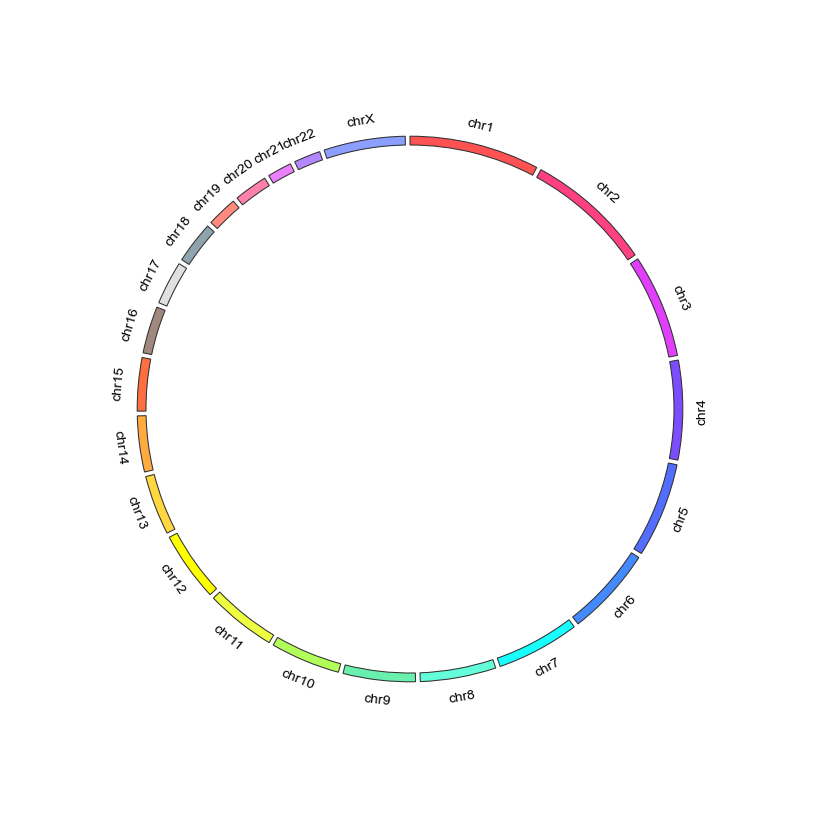

In [187]:
# set chromeosomes
circle = Gcircle()



for idx, row in df_genome_length.iterrows():
    chrom, start, end = row
    length = end - start + 1
    
    arc = Garc(
        arc_id=chrom,  # 染色体名称
        size=length,  # 染色体长度
        interspace=1,  # 间隔距离
        raxis_range=arc_raixs_range,  # 内外半径长度
        labelposition=60,  # 越往里越小，越往外越大
        label_visible=True,  # 是否展示 label，也就是染色体名称
    )
    circle.add_garc(arc)  # 添加一个染色体信息

circle.set_garcs()  # 整合设置所有添加过的染色体信息

##### 整理 cytoband 信息到arcdata\_dict

In [188]:
# 定义不同 cytoband 的颜色
color_dict = {
    "gneg": "#FFFFFF00",
    "gpos25": "#EEEEEE",
    "gpos50": "#BBBBBB",
    "gpos75": "#777777",
    "gpos100": "#000000",
    "gvar": "#FFFFFF00",
    "stalk": "#C01E27",
    "acen": "#D82322"
}

# defaultdict的说明
# https://zhuanlan.zhihu.com/p/46476348
# 其实就是当引用的 key 不存在时返回默认值,这里是默认返回一个 dict 而不抛出 KeyError
arcdata_dict = collections.defaultdict(dict)  # 传入 dict 函数，调用时返回空 dict
# or
# arcdata_dict = collections.defaultdict(lambda: {})
# arcdata_dict

for idx, row in df_genome_cytoband.iterrows():
    chrom, start, end, value1, value2 = row
    width = end - start + 1
    # 在进行arcdata_dict对键chrom 取值取不到的时候
    # 默认创建空 dict 而不是 raise KeyError
    if chrom not in arcdata_dict:
        arcdata_dict[chrom]['positions'] = []
        arcdata_dict[chrom]['widths'] = []
        arcdata_dict[chrom]['colors'] = []
    else:
        arcdata_dict[chrom]['positions'].append(start)
        arcdata_dict[chrom]['widths'].append(width)
        arcdata_dict[chrom]['colors'].append(color_dict[value2])

print(arcdata_dict.__str__()[:1000])

defaultdict(<class 'dict'>, {'chr1': {'positions': [2300000, 5300000, 7100000, 9100000, 12500000, 15900000, 20100000, 23600000, 27600000, 29900000, 32300000, 34300000, 39600000, 43700000, 46300000, 50200000, 55600000, 58500000, 60800000, 68500000, 69300000, 84400000, 87900000, 91500000, 94300000, 99300000, 101800000, 106700000, 111200000, 115500000, 117200000, 120400000, 121700000, 123400000, 125100000, 143200000, 147500000, 150600000, 155100000, 156600000, 159100000, 160500000, 165500000, 167200000, 170900000, 173000000, 176100000, 180300000, 185800000, 190800000, 193800000, 198700000, 207100000, 211300000, 214400000, 223900000, 224400000, 226800000, 230500000, 234600000, 236400000, 243500000], 'widths': [3000001, 1800001, 2000001, 3400001, 3400001, 4200001, 3500001, 4000001, 2300001, 2400001, 2000001, 5300001, 4100001, 2600001, 3900001, 5400001, 2900001, 2300001, 7700001, 800001, 15100001, 3500001, 3600001, 2800001, 5000001, 2500001, 4900001, 4500001, 4300001, 1700001, 3200001, 13000

##### 将 cytoband 信息加到 circle 对象中去

In [189]:
for chrom in arcdata_dict:
    circle.barplot(
        chrom,
        data=[1] * len(arcdata_dict[chrom]['positions']),
        positions=arcdata_dict[chrom]['positions'],
        width=arcdata_dict[chrom]['widths'],
        raxis_range=arc_raixs_range,
        facecolor=arcdata_dict[chrom]['colors']
    )

##### 查看绘制的circos plot骨架

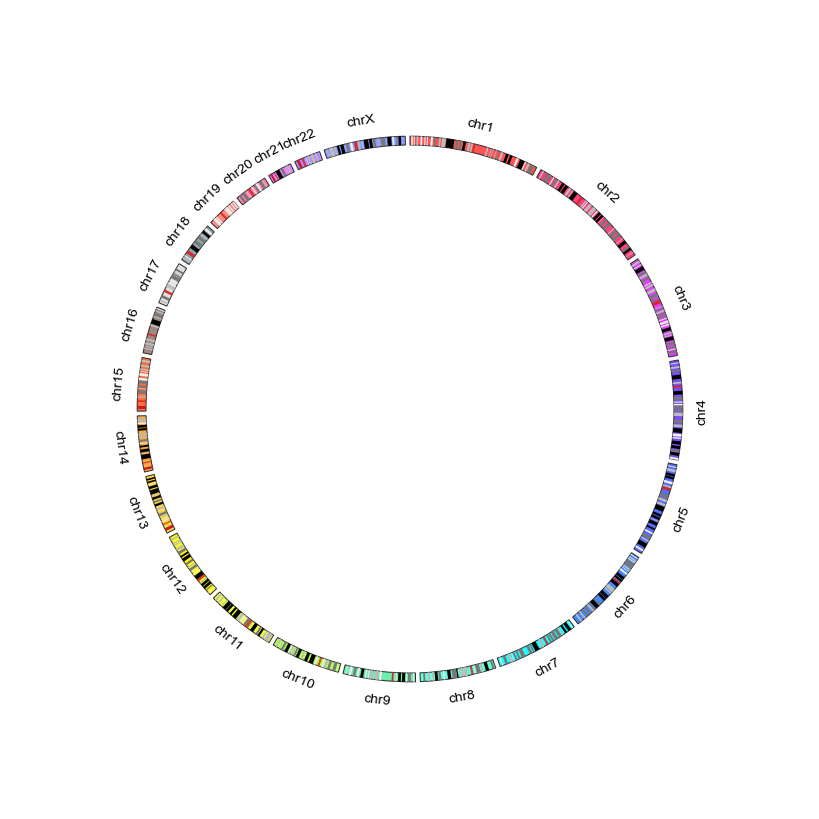

In [190]:
# circle.figure?
circle.figure

##### 添加每个样本中的 off-target sites 信息

DetectSeq_ATP8-DddA11_REP-1 390
DetectSeq_ATP8-DddA6_REP-1 1062
DetectSeq_ATP8-DddAwt_REP-1 198
DetectSeq_JAK2-DddA11_REP-1 1122
DetectSeq_SIRT6-DddA11_REP-1 4229


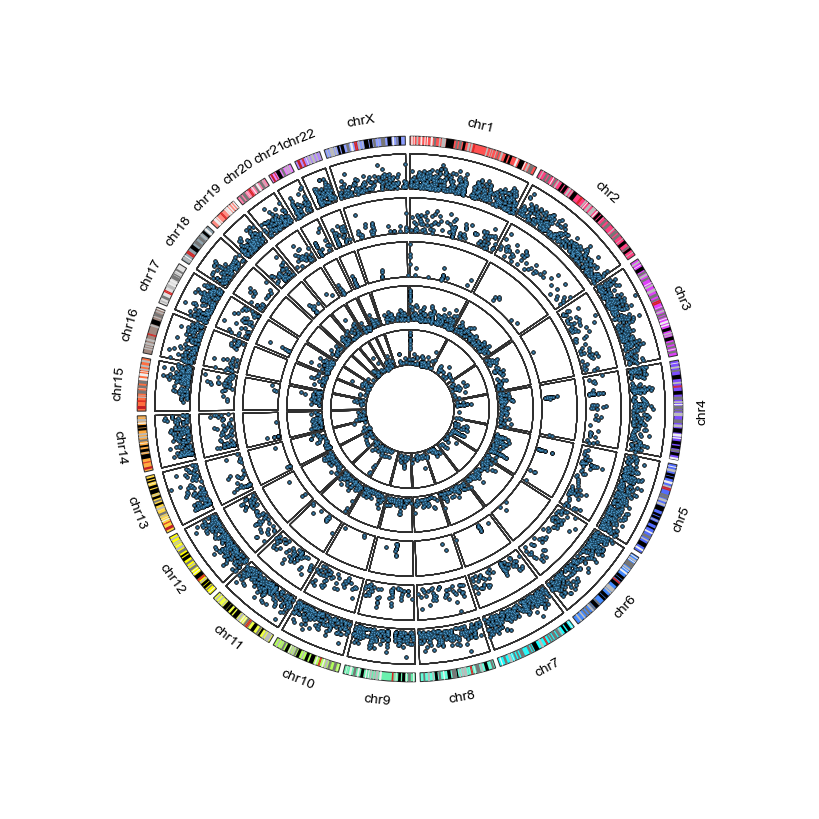

In [212]:
# TODO
# sample lable
# background color
# point color
# edge color of point

#scatter plot
counter_circle = 0
# color

for sample, sample_df in df_circos_point.groupby('sample'):
    print(sample, sample_df.shape[0])
    counter_circle += 1
    
    values_all   = [] 
    arcdata_dict = collections.defaultdict(dict)
    
    for idx, row in sample_df.iterrows():
        _, chrom, start, end, score = row
        middle = (start + end) / 2
        values_all.append(score)
        
        if chrom not in arcdata_dict:
            arcdata_dict[chrom]["positions"] = []
            arcdata_dict[chrom]["values"] = []
        else:
            arcdata_dict[chrom]["positions"].append(middle) 
            arcdata_dict[chrom]["values"].append(score)
    
    vmin, vmax = min(values_all), max(values_all)
    
    arc_raixs_range_sample = (
        (counter_circle * 100.0) * scale, 
        (counter_circle * 100.0 + 80) * scale
    ) 

    for chrom in arcdata_dict:
        circle.scatterplot(
            chrom, 
            data=arcdata_dict[chrom]["values"], 
            positions=arcdata_dict[chrom]["positions"], 
            rlim=[vmin - 0.05 * abs(vmin), vmax + 0.05 * abs(vmax)],
            markershape='o',
            markersize=1,
            raxis_range=arc_raixs_range_sample, 
            facecolor="#468FBE",
            edgecolor="#000000",
            linewidth=0.03,
            spine=True
        )

circle.figure

In [211]:
circle.figure?

Type:           Figure
String form:    Figure(800x800)
File:           /usr/local/Caskroom/miniconda/base/lib/python3.10/site-packages/matplotlib/figure.py
Docstring:     
The top level container for all the plot elements.

Attributes
----------
patch
    The `.Rectangle` instance representing the figure background patch.

suppressComposite
    For multiple images, the figure will make composite images
    depending on the renderer option_image_nocomposite function.  If
    *suppressComposite* is a boolean, this will override the renderer.
Init docstring:
Parameters
----------
figsize : 2-tuple of floats, default: :rc:`figure.figsize`
    Figure dimension ``(width, height)`` in inches.

dpi : float, default: :rc:`figure.dpi`
    Dots per inch.

facecolor : default: :rc:`figure.facecolor`
    The figure patch facecolor.

edgecolor : default: :rc:`figure.edgecolor`
    The figure patch edge color.

linewidth : float
    The linewidth of the frame (i.e. the edge linewidth of the figure
  


### upset plot

## signal strength

### scatter plot

## alignment
### art plot

## editing window
### indel comparation

## ctcf analysis
### shared off-target motif
### DddAwt,6,11 co-localization with ctcf